In [1]:
import os

In [2]:
os.getenv("PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/chrombpnet2/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/bin:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/bin:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/bin:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/bin:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/bin:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/bin:/cluster/apps/nss/jupyterhub/3.5.1/bin:/cluster/apps/gcc-8.2.0/git-2.31.1-q45wg6avfyvko4weuhmnpghaag45ynoo/bin:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/bin:/cluster/apps/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/bin:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/bin:/cluster/apps/local:/cluster/apps/sfos/bin:/usr/local/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/sbin:/bin:/cluster/slurm/

In [3]:
os.getenv("LD_LIBRARY_PATH")

'/cluster/project/treutlein/jjans/software/miniforge3/envs/cuda11_env/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet2/lib:/cluster/project/treutlein/jjans/software/miniforge3/envs/chrompbnet/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib:/cluster/apps/gcc-8.2.0/cudnn-8.9.2.26-ogi7ed2h6ejs7vumekv46idqqas4axgq/lib:/cluster/apps/gcc-8.2.0/cuda-12.1.1-mpwcqkwqghc7y2at5a6wuuhbgmm6efux/lib64:/cluster/apps/gcc-8.2.0/nccl-2.11.4-1-pwkiz23vbeac3vt5ykybdwzaykprizb2/lib:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/apps/gcc-8.2.0/zlib-1.2.9-roj3c3p7lbd2kn3gstlt4rxdcgvb3csi/lib:/cluster/apps/gcc-8.2.0/eccodes-2.21.0-o4xitaateyj4fuopb6chuxme7d5bp4zp/lib64:/cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/lib:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/lib:/cluster/apps/gcc-8.2.

In [4]:
# Adapted from chrombpnet-lite

import deepdish as dd
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import shap
import pyfaidx
import shutil
import errno
import os


In [5]:
import argparse
import chrombpnet.evaluation.interpret.shap_utils as shap_utils
import chrombpnet.evaluation.interpret.input_utils as input_utils

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]


In [6]:
# disable eager execution so shap deep explainer wont break
tf.compat.v1.disable_eager_execution()


In [7]:
def fetch_interpret_args():
    parser = argparse.ArgumentParser(description="get sequence contribution scores for the model")
    parser.add_argument("-g", "--genome", type=str, required=True, help="Genome fasta")
    parser.add_argument("-r", "--regions", type=str, required=True, help="10 column bed file of peaks. Sequences and labels will be extracted centered at start (2nd col) + summit (10th col).")
    parser.add_argument("-m", "--model_h5", type=str, required=True, help="Path to trained model, can be both bias or chrombpnet model")
    parser.add_argument("-o", "--output-prefix", type=str, required=True, help="Output prefix")
    parser.add_argument("-d", "--debug_chr", nargs="+", type=str, default=None, help="Run for specific chromosomes only (e.g. chr1 chr2) for debugging")
    parser.add_argument("-p", "--profile_or_counts", nargs="+", type=str, default=["counts", "profile"], choices=["counts", "profile"],
                        help="use either counts or profile or both for running shap")

    args = parser.parse_args()
    return args


In [8]:
def generate_shap_dict(seqs, scores):
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1)).astype(np.int8)},
            'shap': {'seq': np.transpose(scores, (0, 2, 1)).astype(np.float16)},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1)).astype(np.float16)}
        }

    return d


In [9]:
def interpret(model, seqs, output_prefix, profile_or_counts,save_files=True):
    print("Seqs dimension : {}".format(seqs.shape))

    outlen = model.output_shape[0][1]

    profile_model_input = model.input
    profile_input = seqs
    counts_model_input = model.input
    counts_input = seqs

    if "counts" in profile_or_counts:
        profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
            (counts_model_input, tf.reduce_sum(model.outputs[1], axis=-1)),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'counts' shap scores")
        counts_shap_scores = profile_model_counts_explainer.shap_values(
            counts_input, progress_message=100)

        counts_scores_dict = generate_shap_dict(seqs, counts_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'counts' scores")

            dd.io.save("{}.counts_scores.h5".format(output_prefix),
                        counts_scores_dict,
                        compression='blosc')

#            del counts_shap_scores, counts_scores_dict

    if "profile" in profile_or_counts:
        weightedsum_meannormed_logits = shap_utils.get_weightedsum_meannormed_logits(model)
        profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
            (profile_model_input, weightedsum_meannormed_logits),
            shap_utils.shuffle_several_times,
            combine_mult_and_diffref=shap_utils.combine_mult_and_diffref)

        print("Generating 'profile' shap scores")
        profile_shap_scores = profile_model_profile_explainer.shap_values(
            profile_input, progress_message=100)

        profile_scores_dict = generate_shap_dict(seqs, profile_shap_scores)

        if save_files:
            # save the dictionary in HDF5 formnat
            print("Saving 'profile' scores")
            dd.io.save("{}.profile_scores.h5".format(output_prefix),
                        profile_scores_dict,
                        compression='blosc')
    
    results = {}
    results['profile'] = ''
    results['counts_scores'] = ''
    results['counts_shap'] = ''
    if "profile" in profile_or_counts:
        results['profile'] = profile_scores_dict
    if "counts" in profile_or_counts:
        results['counts_scores'] = counts_scores_dict
        results['counts_shap'] = counts_shap_scores

    return(results)


In [10]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv("regions_of_interest/IGFBP2_regions_peaks_human.bed", sep='\t', names=NARROWPEAK_SCHEMA)


In [11]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit
0,chr2,216636508,216637488,human_peaks_peak_48293,380,.,5.29416,40.7695,38.0041,799


In [12]:
import os
import sys
import os
import sys
import tensorflow as tf
import numpy as np
import chrombpnet.training.utils.losses as losses
from chrombpnet.training.utils.data_utils import one_hot
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model


def get_seq(peaks_df, genome, width):
    """
    Same as get_cts, but fetches sequence from a given genome.
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)

    return one_hot.dna_to_one_hot(vals), np.array(peaks_used)



In [13]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

got the model
got the model
got the model
got the model
got the model


In [14]:
# infer input length
inputlen = model.input_shape[1] # if bias model (1 input only)
print("inferred model inputlen: ", inputlen)


inferred model inputlen:  2114


In [15]:
genome_path = 'encode_data/hg38.fa'
region_index = 0
#region 0 contains the human chimp divergent SNCs

import pyfaidx
genome_path = 'encode_data/hg38.fa'
genome = pyfaidx.Fasta(genome_path)
width = input_len = inputlen
chrom=regions_df.loc[region_index,'chr']
start,end = regions_df.loc[region_index,'start'],regions_df.loc[region_index,'end']
summit = regions_df.loc[region_index,'summit']

start_use = int(start+summit - input_len/2)+1
end_use = int(start + summit + input_len/2)

middle = int((start+end)/2)
nstart = middle-int(input_len/2)
nend = nstart + input_len

#fasta format
seq_man = genome.get_seq(chrom,start_use,end_use)

#string
seq_man2 = str(genome[chrom][(start_use-1):(end_use)])


sequence = seq_man2
vals = []
if len(sequence) == width:
    vals.append(sequence)


In [16]:
human_SNCs = pd.read_csv("extra_data/hg38_panTro6_IGFBP2i_divergent_site.tsv",sep="\t",usecols=[0,1,2,3,4])
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')
human_SNCs['pos'] = human_SNCs['pos(hg38)'] - 216636250 #subtract int_start and 1
human_SNCs['d_start'] = human_SNCs['pos(hg38)']-start_use
human_SNCs['d_start_match'] = [sequence[x] for x in human_SNCs['d_start']]
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')

In [17]:
human_SNCs['Hg38'] = human_SNCs['Human']
human_SNCs['panTro6'] = human_SNCs['Chimp']

In [18]:
human_SNCs

,level_0,index,ID,chr,pos(hg38),Human,Chimp,pos,d_start,d_start_match,Hg38,panTro6
0,0,0,ID_0,chr2,216638002,G,A,1752,1751,G,G,A
1,1,1,ID_1,chr2,216636815,G,A,565,564,G,G,A
2,2,2,ID_2,chr2,216636845,T,C,595,594,T,T,C
3,3,3,ID_3,chr2,216636873,C,T,623,622,C,C,T
4,4,4,ID_4,chr2,216636888,G,A,638,637,G,G,A


In [19]:
def evo_seq(sequence,position,ref,alt):
    if sequence[position]==ref:
        mod_seq = sequence[:position] + alt + sequence[position + 1:]
    else:
        print("reference does not occur at position, double check position")
        mod_seq = None
    return(mod_seq)

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)



In [20]:
def generate_binary_combinations(num_bits):
    num_combinations = 2 ** num_bits
    format_string = f'{{:0{num_bits}b}}'
    combinations = []
    for i in range(num_combinations):
        binary_string = format_string.format(i)
        combinations.append([int(bit) for bit in binary_string])
    return combinations

# Example usage for 12 binary variables
num_variables = len(human_SNCs.index)
combinations = generate_binary_combinations(num_variables)

In [21]:
all_mutated_sequences = []
all_mutated_sequences_df = []
i = 0
ref_sequences = []

for comb in combinations:
    positions = np.where(np.array(comb) == 1)[0]
    human_SNCs_comb = human_SNCs.iloc[positions].copy()

#    if len(human_SNCs_comb.index)==0:
#        comb_sequence = sequence

    comb_sequence = sequence
    
    for SNC in human_SNCs_comb.index:
        position,ref,alt = human_SNCs_comb.loc[SNC,'d_start'],human_SNCs_comb.loc[SNC,'Hg38'],human_SNCs_comb.loc[SNC,'panTro6']

        comb_sequence = evo_seq(comb_sequence,position,ref,alt)

    
    all_mutated_sequences.append(comb_sequence)
    ref_sequences.append(sequence)
    
    concatenated_ids = "_".join(human_SNCs_comb['ID'])
    total_mutations = np.sum(comb)
    
    all_mutated_sequences_df.append(dict(sequence_id=i,ntot=total_mutations,SNC=concatenated_ids))
    i+=1

In [22]:
all_mutated_sequences_df = pd.DataFrame(all_mutated_sequences_df)
all_mutated_sequences_ohe = one_hot.dna_to_one_hot(all_mutated_sequences)
ref_sequences_ohe = one_hot.dna_to_one_hot(ref_sequences)

In [23]:
#ref_batch_preds = model.predict(ref_sequences_ohe)


In [24]:
import time

In [25]:
import random
random.seed(42)

In [26]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    ref_logcount_preds=[]
    alt_logcount_preds=[]
    ref_prob_preds=[]
    alt_prob_preds=[]

    print("predict reference sequence")
    ref_batch_preds = model.predict(ref_sequences_ohe)
    time.sleep(5)

    print("predict mutations sequence")
    alt_batch_preds = model.predict(all_mutated_sequences_ohe)
    time.sleep(5)

    ref_logcount_preds.extend(np.squeeze(ref_batch_preds[1]))
    alt_logcount_preds.extend(np.squeeze(alt_batch_preds[1]))
    
    ref_prob_preds.extend(np.squeeze(softmax(ref_batch_preds[0])))
    alt_prob_preds.extend(np.squeeze(softmax(alt_batch_preds[0])))

    ref_logcount_preds = np.array(ref_logcount_preds)
    alt_logcount_preds = np.array(alt_logcount_preds)
    ref_prob_preds = np.array(ref_prob_preds)
    alt_prob_preds = np.array(alt_prob_preds)

    from scipy.spatial.distance import jensenshannon
    
    log_counts_diff = alt_logcount_preds - ref_logcount_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)*np.sign(log_counts_diff)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])*np.sign(log_counts_diff)

    all_mutated_sequences_df[fold+'--logcount_preds'] = alt_logcount_preds
    all_mutated_sequences_df[fold+'--log_counts_diff'] = log_counts_diff
    all_mutated_sequences_df[fold+'--log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
    all_mutated_sequences_df[fold+'--probs_jsd_diff'] = probs_jsd_diff

fold_0
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_1
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_2
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_3
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence
fold_4
got the model
predict reference sequence


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


predict mutations sequence


In [27]:
log_counts_diff_columns = [x for x in all_mutated_sequences_df.columns if 'log_counts_diff' in x]
log_probs_diff_abs_sum_columns = [x for x in all_mutated_sequences_df.columns if 'log_probs_diff_abs_sum' in x]
probs_jsd_diff_columns = [x for x in all_mutated_sequences_df.columns if 'probs_jsd_diff' in x]
logcount_preds_columns = [x for x in all_mutated_sequences_df.columns if 'logcount_preds' in x]

In [28]:
all_mutated_sequences_df['log_counts_diff_avg'] = all_mutated_sequences_df[log_counts_diff_columns].T.mean()
all_mutated_sequences_df['logcount_preds_avg'] = all_mutated_sequences_df[logcount_preds_columns].T.mean()

all_mutated_sequences_df['log_probs_diff_abs_sum_avg'] = all_mutated_sequences_df[log_probs_diff_abs_sum_columns].T.mean()
all_mutated_sequences_df['probs_jsd_diff_avg'] = all_mutated_sequences_df[probs_jsd_diff_columns].T.mean()

In [29]:
all_mutated_sequences_df.to_csv("SNC_IGFBP2_study_effects_wcounts.tsv",sep="\t")

In [30]:
all_mutated_sequences_df.to_csv("SNC_IGFBP2_study_effects.tsv",sep="\t")

In [31]:
all_mutated_sequences_df

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,6.833225,0.000000,0.000000,0.000000,6.716840,0.000000,0.000000,...,0.000000,0.000000,6.598041,0.000000,0.000000,0.000000,0.000000,6.651723,0.000000,0.000000
1,1,1,ID_4,6.638362,-0.194863,-84.390945,-0.039753,6.548262,-0.168579,-68.829819,...,-229.828857,-0.092687,6.351476,-0.246565,-140.442535,-0.059369,-0.266680,6.385043,-141.136429,-0.059589
2,2,1,ID_3,6.908408,0.075182,33.376160,0.017666,6.784744,0.067904,42.209888,...,28.959709,0.014956,6.710413,0.112372,59.539883,0.026189,0.090242,6.741964,52.933197,0.023889
3,3,2,ID_3_ID_4,6.714245,-0.118980,-43.872704,-0.024578,6.600187,-0.116653,-46.258316,...,-198.313690,-0.080159,6.474278,-0.123763,-57.537403,-0.026591,-0.188454,6.463269,-88.342102,-0.039497
4,4,1,ID_2,6.869263,0.036038,19.356945,0.013294,6.733350,0.016510,22.509020,...,-10.728277,-0.009528,6.600073,0.002033,17.331200,0.014218,0.007536,6.659259,7.298970,0.004223
5,5,2,ID_2_ID_4,6.676192,-0.157033,-66.029663,-0.031988,6.556505,-0.160335,-60.463684,...,-244.163391,-0.098747,6.354335,-0.243705,-134.351837,-0.057335,-0.261388,6.390335,-137.238159,-0.058376
6,6,2,ID_2_ID_3,6.947199,0.113974,49.575054,0.027575,6.799324,0.082483,64.620972,...,28.025793,0.016663,6.709045,0.111004,67.227264,0.032270,0.096637,6.748360,62.098396,0.030563
7,7,3,ID_2_ID_3_ID_4,6.757178,-0.076047,-33.062180,-0.023444,6.607722,-0.109118,-38.506508,...,-211.703812,-0.085951,6.471277,-0.126764,-59.454163,-0.029807,-0.183848,6.467874,-86.749290,-0.041034
8,8,1,ID_1,6.839322,0.006096,9.928485,0.012224,6.747108,0.030267,14.280170,...,8.058056,0.010833,6.603245,0.005204,11.884699,0.011219,0.013365,6.665088,11.224241,0.011421
9,9,2,ID_1_ID_4,6.647251,-0.185974,-88.991043,-0.043357,6.573060,-0.143780,-59.301155,...,-221.167084,-0.089891,6.360095,-0.237946,-138.040649,-0.059129,-0.249972,6.401752,-137.320145,-0.059308


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_mutated_sequences_df = pd.read_csv("region_scores/enterocytes/SNC_IGFBP2_study/SNC_IGFBP2_study_effects_wcounts.tsv",sep="\t")

In [3]:
import seaborn as sns

<Axes: xlabel='ntot', ylabel='probs_jsd_diff_avg'>

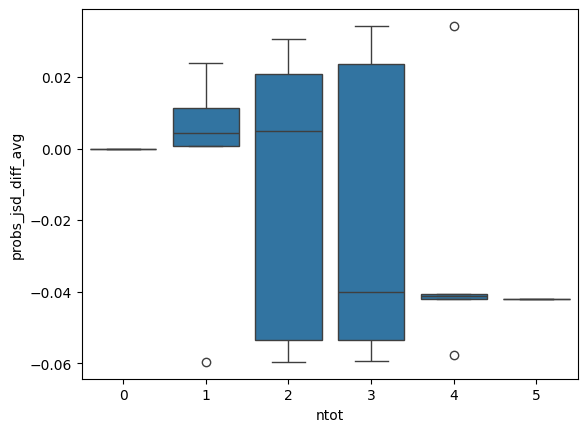

In [4]:
sns.boxplot(x='ntot',y='probs_jsd_diff_avg',data=all_mutated_sequences_df)

In [12]:
all_mutated_sequences_df_onemut = all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']<2].copy()

In [13]:
all_mutated_sequences_df_onemut = all_mutated_sequences_df_onemut[['sequence_id', 'ntot', 'SNC','log_counts_diff_avg', 'logcount_preds_avg','log_probs_diff_abs_sum_avg', 'probs_jsd_diff_avg']]

In [15]:
# Update 'SNC' column by incrementing the IDs
def increment_id(snc):
    if isinstance(snc, str) and snc.startswith("ID_"):
        id_number = int(snc.split("_")[1])  # Extract the number
        return f"ID_{id_number + 1}"       # Increment and format back
    return snc  # Leave as is if not an ID

all_mutated_sequences_df_onemut["SNC"] = all_mutated_sequences_df_onemut["SNC"].apply(increment_id)

In [16]:
all_mutated_sequences_df_onemut

,sequence_id,ntot,SNC,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,NaN,0.000000,6.651723,0.000000,0.000000
1,1,1,ID_5,-0.266680,6.385043,-141.136430,-0.059589
2,2,1,ID_4,0.090242,6.741964,52.933197,0.023889
4,4,1,ID_3,0.007536,6.659259,7.298970,0.004223
8,8,1,ID_2,0.013365,6.665088,11.224241,0.011421
16,16,1,ID_1,0.000143,6.651866,1.305019,0.000584


In [8]:
all_mutated_sequences_df_onemut.columns

Index(['Unnamed: 0', 'sequence_id', 'ntot', 'SNC', 'fold_0--logcount_preds',
       'fold_0--log_counts_diff', 'fold_0--log_probs_diff_abs_sum',
       'fold_0--probs_jsd_diff', 'fold_1--logcount_preds',
       'fold_1--log_counts_diff', 'fold_1--log_probs_diff_abs_sum',
       'fold_1--probs_jsd_diff', 'fold_2--logcount_preds',
       'fold_2--log_counts_diff', 'fold_2--log_probs_diff_abs_sum',
       'fold_2--probs_jsd_diff', 'fold_3--logcount_preds',
       'fold_3--log_counts_diff', 'fold_3--log_probs_diff_abs_sum',
       'fold_3--probs_jsd_diff', 'fold_4--logcount_preds',
       'fold_4--log_counts_diff', 'fold_4--log_probs_diff_abs_sum',
       'fold_4--probs_jsd_diff', 'log_counts_diff_avg', 'logcount_preds_avg',
       'log_probs_diff_abs_sum_avg', 'probs_jsd_diff_avg'],
      dtype='object')

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

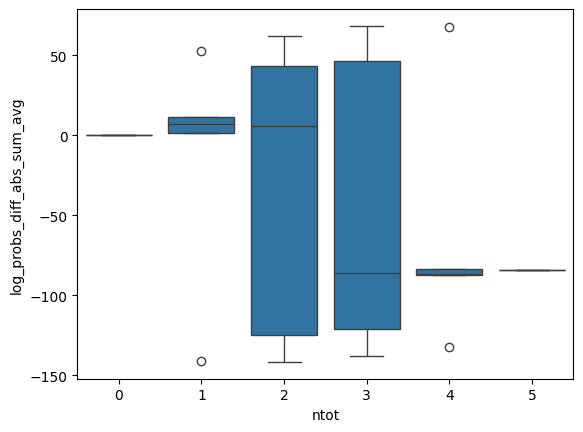

In [34]:
sns.boxplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_probs_diff_abs_sum_avg'>

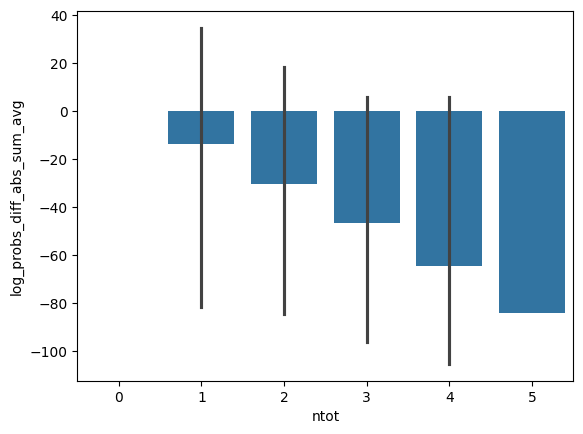

In [35]:
sns.barplot(x='ntot',y='log_probs_diff_abs_sum_avg',data=all_mutated_sequences_df)

<Axes: xlabel='ntot', ylabel='log_counts_diff_avg'>

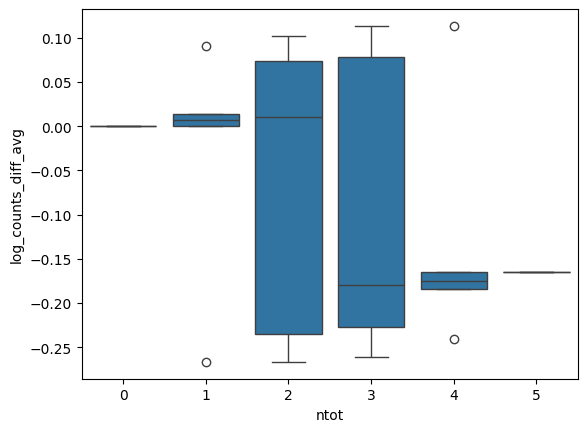

In [36]:
sns.boxplot(x='ntot',y='log_counts_diff_avg',data=all_mutated_sequences_df)

In [37]:
SNC_info['log_counts_diff'] = log_counts_diff
SNC_info['log_probs_diff_abs_sum'] = log_probs_diff_abs_sum
SNC_info['probs_jsd_diff'] = probs_jsd_diff


NameError: name 'SNC_info' is not defined

In [38]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot']==1].sort_values(by='SNC')

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
16,16,1,ID_0,6.834239,0.001013,1.461514,0.000649,6.719839,0.002998,2.456373,...,1.736870,0.000867,6.592869,-0.005172,-1.718345,-0.000708,0.000143,6.651865,1.305019,0.000584
8,8,1,ID_1,6.839322,0.006096,9.928485,0.012224,6.747108,0.030267,14.280170,...,8.058056,0.010833,6.603245,0.005204,11.884699,0.011219,0.013365,6.665088,11.224241,0.011421
4,4,1,ID_2,6.869263,0.036038,19.356945,0.013294,6.733350,0.016510,22.509020,...,-10.728277,-0.009528,6.600073,0.002033,17.331200,0.014218,0.007536,6.659259,7.298970,0.004223
2,2,1,ID_3,6.908408,0.075182,33.376160,0.017666,6.784744,0.067904,42.209888,...,28.959709,0.014956,6.710413,0.112372,59.539883,0.026189,0.090242,6.741964,52.933197,0.023889
1,1,1,ID_4,6.638362,-0.194863,-84.390945,-0.039753,6.548262,-0.168579,-68.829819,...,-229.828857,-0.092687,6.351476,-0.246565,-140.442535,-0.059369,-0.266680,6.385043,-141.136429,-0.059589


In [51]:
sns.boxplot(x='ntot',y='log_counts_diff',data=all_mutated_sequences_df)

ValueError: Could not interpret value `log_counts_diff` for `y`. An entry with this name does not appear in `data`.

In [39]:
len(all_mutated_sequences_ohe)

32

In [40]:
len(all_mutated_sequences_ohe[0])

2114

In [41]:
all_mutated_sequences_df.loc[all_mutated_sequences_df['ntot'].isin([0,5])]

,sequence_id,ntot,SNC,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
0,0,0,,6.833225,0.00000,0.000000,0.000000,6.716840,0.000000,0.000000,...,0.000000,0.000000,6.598041,0.000000,0.000000,0.000000,0.000000,6.651723,0.000000,0.000000
31,31,5,ID_0_ID_1_ID_2_ID_3_ID_4,6.763645,-0.06958,-40.867828,-0.027115,6.653368,-0.063472,-30.300707,...,-203.545898,-0.083289,6.483650,-0.114391,-52.546257,-0.030085,-0.164755,6.486968,-84.358963,-0.042155


In [42]:
all_mutated_sequences_ohe_extremes = np.array([all_mutated_sequences_ohe[0],all_mutated_sequences_ohe[31]])

In [43]:
import tensorflow as tf

# Reset TensorFlow session
tf.keras.backend.clear_session()
import torch

# If using PyTorch:
torch.cuda.empty_cache()

# Optional: Explicit garbage collection
import gc
gc.collect()

190

In [44]:
np.shape(all_mutated_sequences_ohe_extremes[0])

(2114, 4)

In [45]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [46]:
for fold in ['fold_0','fold_1','fold_2','fold_3','fold_4']:
    print(fold)
    model_path = 'celltype_models_human/modelv1_enterocytes/'+fold+'/output/models/chrombpnet_nobias.h5'
    
    custom_objects={"multinomial_nll": losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_path,compile=False)
    print("got the model")

    results = interpret(model, all_mutated_sequences_ohe_extremes, 'SNC_IGFBP2_study_extr_'+fold, ['profile','counts'])

fold_0
got the model
Seqs dimension : (2, 2114, 4)

Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_1
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_2
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_3
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 2
Saving 'profile' scores
fold_4
got the model
Seqs dimension : (2, 2114, 4)
Generating 'counts' shap scores
Done 0 examples of 2
Saving 'counts' scores
Generating 'profile' shap scores
Done 0 examples of 